## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

In [0]:
from google.colab import drive
drive.mount("/content/drive")
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
drive  sample_data


In [0]:
%cd drive/My\ Drive/Colab\ Notebooks/Deep\ Learning\ in\ Computer\ Vision/Week\ 2/facial-keypoints
!ls

/content/drive/My Drive/Colab Notebooks/Deep Learning in Computer Vision/Week 2/facial-keypoints
 data	      'Facial keypoints.ipynb'	 __MACOSX
 example.png   get_data.pyc		 saveImgsPoints.pickle


### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [0]:
from get_data import unpack
unpack('facial-keypoints-data.zip')

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [0]:
import pandas as pd
import os

In [0]:
### Useful routines for preparing data
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize

def load_imgs_and_keypoints(dirname='data'):
    # Write your code for loading images and points here
    images = zeros((6000, 100, 100, 3))
    points = zeros((6000, 28))

    # Iterate over each row
    df = pd.read_csv(join(dirname,"gt.csv"))
    df = df.set_index("filename")
    i = 0

    for imgName in os.listdir(join(dirname, "images")):
      if i % 100 == 0:
        print(i)
      img = imread(join(dirname, "images", imgName))

      
      row = array(df.loc[imgName].tolist(), dtype="float64")
      row[::2] = (row[::2]/img.shape[1]) - 0.5
      row[1::2] = (row[1::2]/img.shape[0]) - 0.5
      points[i] = row
      
      
      img = resize(img, (100,100,3))
      images[i] = img
      i = i+1

    print("images imported.")
      
    resize(image, shape)
    return images, points

imgs, points = load_imgs_and_keypoints()
print(points[0])

array([-0.32926829, -0.25609756, -0.12195122, -0.25609756,  0.09756098,
       -0.25609756,  0.25609756, -0.25609756, -0.25609756, -0.19512195,
       -0.18292683, -0.19512195, -0.1097561 , -0.19512195,  0.1097561 ,
       -0.19512195,  0.19512195, -0.20731707,  0.25609756, -0.2195122 ,
        0.01219512,  0.08536585, -0.08536585,  0.20731707,  0.        ,
        0.23170732,  0.13414634,  0.20731707])

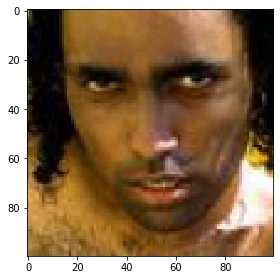

In [0]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[2])
points[2]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

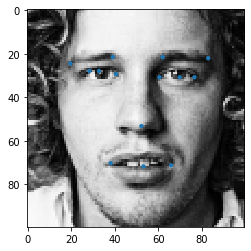

In [0]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    # Create a figure. Equal aspect so circles look circular
    fig,ax = plt.subplots(1)
    ax.set_aspect('equal')

    # Show the image
    ax.imshow(img)

    # Now, loop through coord arrays, and create a circle at each x,y pair
    for i in range(0,points.shape[0],2):
      x = (points[i]+0.5)*100
      y = (points[i+1]+0.5)*100
      circ = Circle((x,y),1)
      ax.add_patch(circ)
    # Show the image
    plt.show()

visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [0]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

In [0]:
import numpy as np

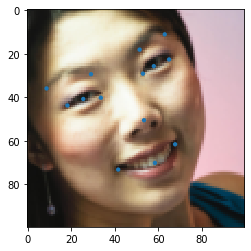

In [0]:
def flip_img(img, points):
    # Write your code for flipping here
    new_img = img[:, ::-1]
    new_points = points.copy()
    new_points[::2] = -points[::2]
    return new_img, new_points

f_img, f_points = flip_img(imgs[5], points[5])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [0]:
# Write your code here
aug_imgs_train = imgs_train.copy()
aug_points_train = points_train.copy()

for i in range(imgs_train.shape[0]):
  im, pt = flip_img(imgs_train[i], points_train[i])

  aug_imgs_train[i] = im
  aug_points_train[i] = pt

aug_imgs_train, aug_points_train

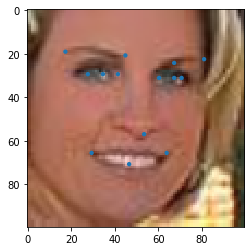

In [0]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

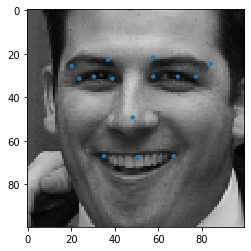

In [0]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

In [0]:
import pickle

In [0]:
PIK = "saveImgsPoints.pickle"
# topickle = [imgs, points]
  # with open(PIK, "wb") as f:
  #     pickle.dump(topickle, f)
with open(PIK, "rb") as f:
    imgs, points = pickle.load(f)
f.close()

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [0]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization
)

# Define here your model
input_shape = (100,100,3)
num_classes = 28

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding = "same",
                 activation='relu',
                 input_shape=input_shape))
# model.add(Conv2D(32, kernel_size=(1, 3), padding = "same",
#                  activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding = "same",
                 activation='relu'))
# model.add(Conv2D(64, kernel_size=(1, 3), padding = "same",
#                  activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), padding = "same",
                 activation='relu'))
# model.add(Conv2D(128, kernel_size=(1, 3), padding = "same",
#                  activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(256, kernel_size=(3, 1), padding = "same",
#                  activation='relu'))
# model.add(Conv2D(256, kernel_size=(1, 3), padding = "same",
#                  activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.3))

model.add(Dense(num_classes))


Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [0]:
batch_size = 32
epochs = 50

In [0]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam

model.compile(loss="mean_squared_error",
              optimizer=Adam(),
              metrics=['accuracy'])
# checkpoint
# filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

filepath="best_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks = [checkpoint]

# fit model
model.fit(imgs_train, points_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(imgs_val, points_val)
          ,callbacks = callbacks
          )

# Choose optimizer, compile model and run training

Train on 5400 samples, validate on 600 samples
Epoch 1/50
5400/5400 [==============================] - 6s 1ms/step - loss: 0.0094 - acc: 0.5711 - val_loss: 0.0025 - val_acc: 0.7750

Epoch 00001: val_acc improved from -inf to 0.77500, saving model to best_weights.hdf5
Epoch 2/50
5400/5400 [==============================] - 3s 474us/step - loss: 0.0029 - acc: 0.7206 - val_loss: 0.0023 - val_acc: 0.7900

Epoch 00002: val_acc improved from 0.77500 to 0.79000, saving model to best_weights.hdf5
Epoch 3/50
5400/5400 [==============================] - 3s 479us/step - loss: 0.0024 - acc: 0.7541 - val_loss: 0.0020 - val_acc: 0.7900

Epoch 00003: val_acc did not improve from 0.79000
Epoch 4/50
5400/5400 [==============================] - 3s 474us/step - loss: 0.0021 - acc: 0.7889 - val_loss: 0.0018 - val_acc: 0.7933

Epoch 00004: val_acc improved from 0.79000 to 0.79333, saving model to best_weights.hdf5
Epoch 5/50
5400/5400 [==============================] - 3s 478us/step - loss: 0.0019 - acc: 0

In [0]:
# load weights
model.load_weights("best_weights.hdf5")
# Compile model (required to make predictions)
model.compile(loss="mean_squared_error",
              optimizer=Adam(),
              metrics=['accuracy'])
print("Created model and loaded weights from file")

Created model and loaded weights from file


In [0]:
score = model.evaluate(imgs_val, points_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0011191337027897437
Test accuracy: 0.8250000007947286


### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

In [0]:
# inputimg = imgs_val[2].copy()
# inputimg.resize(1,100,100,3)
# inputimg.shape
ynew = model.predict(imgs_val)
print(ynew.shape)


(600, 28)


[-0.32957703 -0.22396389 -0.13945018 -0.25987327  0.07100652 -0.28861398
  0.2575736  -0.29920372 -0.26585028 -0.15111464 -0.19896846 -0.17125186
 -0.1218361  -0.16758934  0.09855368 -0.19128555  0.16342148 -0.21206352
  0.23734796 -0.21614203  0.02598118  0.0074314  -0.11779333  0.18535194
  0.04598292  0.18979856  0.19548994  0.14384474]


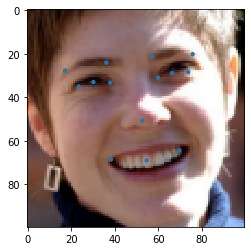

[-0.41154957 -0.12371473 -0.1881915  -0.20622458  0.02685739 -0.31324536
  0.25482583 -0.4215699  -0.30854318 -0.08780941 -0.2456319  -0.12160087
 -0.1404415  -0.14246725  0.09276767 -0.24197671  0.15589173 -0.28309232
  0.26458943 -0.3172475   0.06011228  0.00952952  0.00559246  0.21836354
  0.14500089  0.17093027  0.25614455  0.08548622]


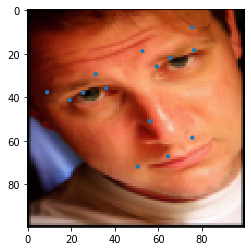

[-0.26588085 -0.30742002 -0.06216358 -0.3051886   0.15192947 -0.27348873
  0.323306   -0.243128   -0.22102785 -0.19699934 -0.14742936 -0.20454481
 -0.08387077 -0.19330111  0.1490143  -0.15444295  0.21146473 -0.16052979
  0.27881485 -0.14784712  0.04511368  0.01319274 -0.117006    0.20493534
  0.01644498  0.20952584  0.13331103  0.23081025]


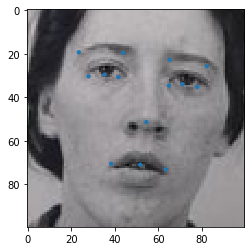

[-0.29297754 -0.32275894 -0.04120419 -0.29074782  0.14825815 -0.27574575
  0.31576526 -0.26243567 -0.25372303 -0.22127648 -0.1731731  -0.21070705
 -0.09073649 -0.18974738  0.12322012 -0.16393681  0.19611534 -0.169903
  0.26158747 -0.16171154  0.04584613  0.06428932 -0.18272951  0.2074028
 -0.01459859  0.23150572  0.09253325  0.22310887]


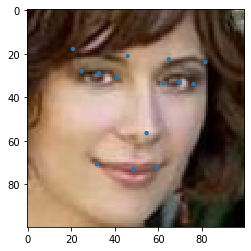

[-0.2975586  -0.27173984 -0.10286456 -0.28580624  0.09220038 -0.289548
  0.2843049  -0.2683255  -0.24538036 -0.20146792 -0.17273968 -0.20953727
 -0.10940745 -0.19930077  0.10417449 -0.1995286   0.16992699 -0.20652415
  0.23890206 -0.19785178 -0.00628     0.00390515 -0.13987741  0.19028717
 -0.00445468  0.19651887  0.12767124  0.19361524]


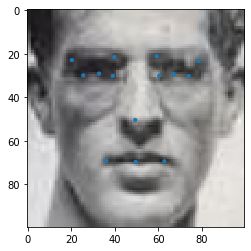

[-0.3164291  -0.29156458 -0.15199967 -0.2673499   0.0245906  -0.27410033
  0.2568536  -0.2929178  -0.27326545 -0.22137788 -0.21310946 -0.21634793
 -0.14510207 -0.21380451  0.05545517 -0.21639776  0.14310245 -0.2173385
  0.2120733  -0.220611   -0.10201394  0.04608412 -0.18667772  0.18346426
 -0.06233444  0.21194331  0.08832923  0.18842404]


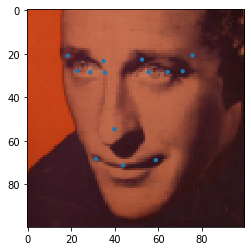

[-0.30014262 -0.25686193 -0.10844418 -0.28575116  0.09862633 -0.28338018
  0.2812976  -0.27596572 -0.2452701  -0.17698851 -0.17415975 -0.18414949
 -0.11263296 -0.17750594  0.11142363 -0.18155146  0.18432489 -0.19095682
  0.2509032  -0.18683094  0.00451718  0.01316611 -0.1482914   0.17198515
  0.01157064  0.18167217  0.16016503  0.16247755]


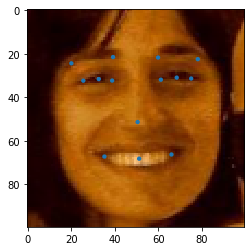

[-0.29256204 -0.2831703  -0.09651551 -0.2915153   0.12458007 -0.2638486
  0.33485085 -0.25193986 -0.24259391 -0.21218109 -0.16557199 -0.20996314
 -0.10073599 -0.19929828  0.12869142 -0.17512578  0.20958585 -0.17573391
  0.28342375 -0.16830043 -0.00684513  0.01888262 -0.16177267  0.1467976
 -0.0101833   0.18554021  0.14442423  0.17064026]


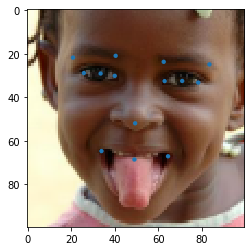

In [0]:
indecies = [50,80,30,150,500,450,300,363]
for index in indecies:
  imtest = imgs_val[index]
  pttest = ynew[index]
  print(pttest)
  visualize_points(imtest, pttest)


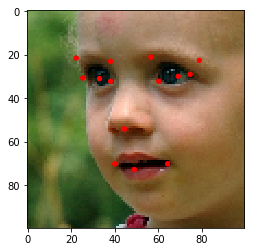

In [0]:
# Example of output